##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 自定义联合算法，第 2 部分：实现联合平均

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/federated/tutorials/custom_federated_algorithms_2"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/federated/blob/v0.34.0/docs/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/federated/blob/v0.34.0/docs/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/federated/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a> </td>
</table>

本系列教程包括两个部分，此为第二部分。该系列演示了如何使用 [Federated Core (FC)](../federated_core.md) 在 TFF 中实现自定义类型的联合算法，它是[联合学习 (FL)](../federated_learning.md) 层（`tff.learning`）的基础。

我们建议您先阅读[本系列的第一部分](custom_federated_algorithms_1.ipynb)，其中介绍了此处使用的一些关键概念和编程抽象。

本系列的第二部分使用第一部分中介绍的机制来实现简单版本的联合训练和评估算法。

我们建议您查看[图像分类](federated_learning_for_image_classification.ipynb)和[文本生成](federated_learning_for_text_generation.ipynb)教程，以获得对 TFF 的 Federated Learning API 更高级和更循序渐进的介绍，因为它们将帮助您在上下文中理解我们在此描述的概念。

## 准备工作

在开始之前，请尝试运行以下“Hello World”示例，以确保您的环境已正确配置。如果无法正常运行，请参阅[安装](../install.md)指南查看说明。

In [2]:
#@test {"skip": true}
!pip install --quiet --upgrade tensorflow-federated-nightly
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

In [3]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

# TODO(b/148678573,b/148685415): must use the reference context because it
# supports unbounded references and tff.sequence_* intrinsics.
tff.backends.reference.set_reference_context()

In [4]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

b'Hello, World!'

## 实现联合平均

与[图像分类联合学习](federated_learning_for_image_classification.ipynb)一样，我们将使用 MNIST 示例，但由于这是一个低级教程，我们将绕过 Keras API 和 `tff.simulation`，编写原始模型代码，并从头开始构造联合数据集。


### 准备联合数据集

为了进行演示，我们将模拟一个场景，其中有来自 10 个用户的数据，每个用户都会提供如何识别不同数字的知识。这是能够得到的最非[独立同分布](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)的情况。

首先，加载标准 MNIST 数据：

In [5]:
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

In [6]:
[(x.dtype, x.shape) for x in mnist_train]

[(dtype('uint8'), (60000, 28, 28)), (dtype('uint8'), (60000,))]

数据以 Numpy 数组的形式出现，一个带有图像，另一个带有数字标签，其中第一个维度都遍历各个样本。我们来编写一个辅助函数，并使用与将联合序列馈送到 TFF 计算的方式相兼容的方式（即作为列表的列表，外部列表包括用户（数字），内部列表包括每个客户端序列中的数据批次）对其进行格式化。按照惯例，我们将每个批次构造为一对名为 `x` 和 `y` 的张量，每个张量都具有与首个批次相同的维度。同时，我们还将每个图像展平为一个具有 784 个元素的向量，并将其中的像素重新缩放到 `0..1` 范围内，这样我们就不必在模型逻辑上进行数据转换了。

In [7]:
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100


def get_data_for_digit(source, digit):
  output_sequence = []
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
    batch_samples = all_samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x':
            np.array([source[0][i].flatten() / 255.0 for i in batch_samples],
                     dtype=np.float32),
        'y':
            np.array([source[1][i] for i in batch_samples], dtype=np.int32)
    })
  return output_sequence


federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]

federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]

作为快速的健全性检查，我们来看一下第五个客户端（对应数字 `5`）所贡献的最后一个数据批次中的 `Y` 张量。

In [8]:
federated_train_data[5][-1]['y']

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

保险起见，我们再检查一下该批次最后一个元素对应的图像。

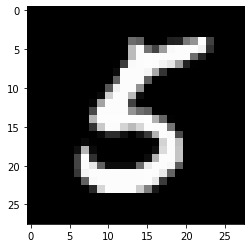

In [9]:
from matplotlib import pyplot as plt

plt.imshow(federated_train_data[5][-1]['x'][-1].reshape(28, 28), cmap='gray')
plt.grid(False)
plt.show()

### 关于 TensorFlow 与 TFF 的结合

在本教程中，出于紧凑考虑，我们使用 `tff.tf_computation` 对引入 TensorFlow 逻辑的函数进行了直接装饰。但对于更复杂的逻辑，我们不建议使用这种模式。调试 TensorFlow 本身就是一种挑战，如果在 TensorFlow 完全序列化并重新导入后再对其进行调试，必然会丢失部分元数据并限制交互性，这会使调试面临更大挑战。

因此，**我们强烈建议将复杂的 TF 逻辑编写为独立的 Python 函数**（即不使用 `tff.tf_computation` 装饰）。这样，在序列化 TFF 计算之前（例如，通过将 Python 函数用作参数调用 `tff.tf_computation`），可以使用 TF 最佳做法和工具（如 Eager 模式）对 TensorFlow 逻辑进行开发和测试。

### 定义损失函数

现在有了数据，我们来定义一个可以用于训练的损失函数。首先，将输入类型定义为 TFF 命名元组。由于数据批次的大小可能会有所不同，因此我们将批次维度设置为 `None`，表示该维度的大小未知。

In [10]:
BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32))
BATCH_TYPE = tff.to_type(BATCH_SPEC)

str(BATCH_TYPE)

'<x=float32[?,784],y=int32[?]>'

您可能想知道为什么我们不能只定义普通的 Python 类型。回想一下[第 1 部分](custom_federated_algorithms_1.ipynb)中讨论的内容，我们解释了虽然可以使用 Python 来表达 TFF 计算的逻辑，但实际上 TFF 计算*不是* Python。上面定义的符号 `BATCH_TYPE` 表示抽象的 TFF 类型规范。区分这种*抽象的* TFF 类型与具体的 Python *表示* 类型（可用来表示 Python 函数主体中 TFF 类型的容器，如 `dict` 或 `collections.namedtuple`）很重要。与 Python 不同，针对类似元组的容器，TFF 具有单个抽象类型构造函数 `tff.StructType`，其元素可以单独命名或不命名。这种类型还用于对计算的形式化参数进行建模，因为 TFF 计算形式上只能声明一个参数和一个结果（稍后您将看到相关示例）。

现在，我们来定义模型参数的 TFF 类型，仍然将其定义为*权重*和*偏差*的 TFF 命名元组。

有了这些定义，现在我们可以在单个批次上定义给定模型的损失。请注意 `@tf.function` 装饰器在 `@tff.tf_computation` 装饰器内部的用法。通过这种用法，即使在由 `tff.tf_computation` 装饰器创建的 `tf.Graph` 上下文中，我们也可以使用类似 Python 的语义来编写 TF。

In [12]:
# NOTE: `forward_pass` is defined separately from `batch_loss` so that it can 
# be later called from within another tf.function. Necessary because a
# @tf.function  decorated method cannot invoke a @tff.tf_computation.

@tf.function
def forward_pass(model, batch):
  predicted_y = tf.nn.softmax(
      tf.matmul(batch['x'], model['weights']) + model['bias'])
  return -tf.reduce_mean(
      tf.reduce_sum(
          tf.one_hot(batch['y'], 10) * tf.math.log(predicted_y), axis=[1]))

@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
  return forward_pass(model, batch)

和预期一样，在给定模型和单个数据批次的情况下，计算 `batch_loss` 返回 `float32` 损失。请注意 `MODEL_TYPE` 和 `BATCH_TYPE` 合并为形式参数的二维元组的方式；您可以将 `batch_loss` 的类型识别为 `(<MODEL_TYPE,BATCH_TYPE> -> float32)`。

In [13]:
str(batch_loss.type_signature)

'(<model=<weights=float32[784,10],bias=float32[10]>,batch=<x=float32[?,784],y=int32[?]>> -> float32)'

作为健全性检查，我们来构造一个用零填充的初始模型，并计算上文中可视化的那批数据的损失。

In [14]:
initial_model = collections.OrderedDict(
    weights=np.zeros([784, 10], dtype=np.float32),
    bias=np.zeros([10], dtype=np.float32))

sample_batch = federated_train_data[5][-1]

batch_loss(initial_model, sample_batch)

2.3025851

请注意，我们使用定义为 `dict` 的初始模型为 TFF 计算馈送数据，即便定义它的 Python 函数的主体将模型参数用作 `model['weight']` 和 `model['bias']` 。`batch_loss` 调用的参数并不是简单地传递给该函数的主体。

当我们调用 `batch_loss` 时会发生什么情况？`batch_loss` 的 Python 主体已在上面的单元格中（在对其进行定义的位置）进行了跟踪和序列化。TFF 在计算定义时充当 `batch_loss` 的调用者，并在 `batch_loss` 被调用时充当调用的目标。在这两个角色中，TFF 均充当 TFF 的抽象类型系统和 Python 表示类型之间的桥梁。在调用时，TFF 将接受大多数标准 Python 容器类型（`dict`、`list`、`tuple`、`collections.namedtuple` 等），以将其作为抽象 TFF 元组的具体表示。虽然我们在上文中提到，TFF 计算在形式上仅接受单个参数，但如果参数的类型是元组，则可以将熟悉的 Python 调用语法与位置和/或关键字参数一起使用，它会按预期工作。

### 单个批次上的梯度下降

现在，我们来定义一个使用下面的损失函数来执行单步梯度下降的计算。请注意我们在定义此函数时，如何将 `batch_loss` 用作子组件。您可以在另一个计算的主体内部调用使用 `tff.tf_computation` 构造的计算，但正如我们在上文中提到的，您通常没有必要进行此操作。这是因为，序列化会丢失部分调试信息，因此对于不使用 `tff.tf_computation` 装饰器来编写和测试所有 TensorFlow 的更复杂的计算来说，这种方式更加可取。

In [15]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
  # Define a group of model variables and set them to `initial_model`. Must
  # be defined outside the @tf.function.
  model_vars = collections.OrderedDict([
      (name, tf.Variable(name=name, initial_value=value))
      for name, value in initial_model.items()
  ])
  optimizer = tf.keras.optimizers.SGD(learning_rate)

  @tf.function
  def _train_on_batch(model_vars, batch):
    # Perform one step of gradient descent using loss from `batch_loss`.
    with tf.GradientTape() as tape:
      loss = forward_pass(model_vars, batch)
    grads = tape.gradient(loss, model_vars)
    optimizer.apply_gradients(
        zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
    return model_vars

  return _train_on_batch(model_vars, batch)

In [16]:
str(batch_train.type_signature)

'(<initial_model=<weights=float32[784,10],bias=float32[10]>,batch=<x=float32[?,784],y=int32[?]>,learning_rate=float32> -> <weights=float32[784,10],bias=float32[10]>)'

当您在另一个此类函数的主体中调用使用 `tff.tf_computation` 装饰的 Python 函数时，内部 TFF 计算的逻辑会嵌入（本质上为内嵌）到外部计算的逻辑中。如上所述，如果要编写这两个计算，最好将内部函数（在本例中为 `batch_loss`）设置为常规 Python 或 `tf.function` 函数，而非 `tff.tf_computation` 函数。但这里我们演示了，在 `tff.tf_computation` 内部调用与其相同的函数基本上可以按预期工作。例如，如果您没有定义 `batch_loss` 的 Python 代码，而只有它的序列化 TFF 表示，则可能必须进行此操作。

现在，将这个函数在初始模型上应用几次，以查看损失是否会减少。

In [17]:
model = initial_model
losses = []
for _ in range(5):
  model = batch_train(model, sample_batch, 0.1)
  losses.append(batch_loss(model, sample_batch))

In [18]:
losses

[0.19690023, 0.13176313, 0.10113225, 0.08273812, 0.070301384]

### 本地数据序列上的梯度下降

现在，由于 `batch_train` 似乎可以正常工作，我们来编写一个类似的训练函数 `local_train`，它会使用一个用户所有批次的整个序列，而不仅仅是一个批次。现在，新的计算将需要使用 `tff.SequenceType(BATCH_TYPE)` 而不是 `BATCH_TYPE`。

In [19]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):

  @tff.tf_computation(LOCAL_DATA_TYPE, tf.float32)
  def _insert_learning_rate_to_sequence(dataset, learning_rate):
    return dataset.map(lambda x: (x, learning_rate))

  batches_with_learning_rate = _insert_learning_rate_to_sequence(all_batches, learning_rate)

  # Mapping function to apply to each batch.
  @tff.federated_computation(MODEL_TYPE, batches_with_learning_rate.type_signature.element)
  def batch_fn(model, batch_with_lr):
    batch, lr = batch_with_lr
    return batch_train(model, batch, lr)

  return tff.sequence_reduce(batches_with_learning_rate, initial_model, batch_fn)

In [20]:
str(local_train.type_signature)

'(<initial_model=<weights=float32[784,10],bias=float32[10]>,learning_rate=float32,all_batches=<x=float32[?,784],y=int32[?]>*> -> <weights=float32[784,10],bias=float32[10]>)'

这段简短的代码中包含了很多细节，我们将逐一进行介绍。

首先，虽然我们完全可以用 TensorFlow 实现此逻辑，像之前那样利用 `tf.data.Dataset.reduce` 来处理序列，但这次我们选择用胶水语言将此逻辑表达为 `tff.federated_computation`。我们已使用联合算子 `tff.sequence_reduce` 来执行归约。

算子 `tff.sequence_reduce` 的用法类似于 `tf.data.Dataset.reduce`。您可以认为它在本质上与 `tf.data.Dataset.reduce` 相同，但是前者用于联合计算内部（您也许还记得，它不能包含 TensorFlow 代码）。它是一个模板算子，其形式参数三维元组由 `T` 型元素的*序列*、某种类型 `U` 的归约初始状态（我们将其抽象地称为*零*），以及类型 `(<U,T> -> U)` 的*归约算子*（通过处理单个元素改变归约状态）组成。得到的结果是按顺序处理所有元素后归约的最终状态。在我们的示例中，归约状态是在数据前缀上训练的模型，且元素是数据批次。

其次，请注意，我们再次将一个计算（`batch_train`）用作了另一个计算（`local_train`）中的组件，而非直接使用。我们不能将其用作归约算子，因为它需要一个额外参数，即学习率。为了解决这个问题，我们定义一个嵌入式联合计算 `batch_fn`，该计算绑定到其主体中 `local_train` 的参数 `learning_rate`。因此，以这种方式定义的子计算可以捕获其父级的形式参数，只要子计算未在其父级的主体之外调用。您可以将此模式视为 Python 中 `functools.partial` 的等效项。

当然，以这种方式捕获 `learning_rate` 的实际含义是，在所有批次中都使用相同的学习率值。

现在，我们在整个数据序列上尝试新定义的本地训练函数，该数据序列由贡献了样本批次的同一用户（数字 `5`）提供。

In [21]:
locally_trained_model = local_train(initial_model, 0.1, federated_train_data[5])

有效果吗？为了回答这个问题，我们需要实现评估。

### 本地评估

下面是一种通过将所有数据批次的损失加总起来实现本地评估的方法（也可以算出平均值；我们将把它作为练习留给读者）。

In [22]:
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):

  @tff.tf_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
  def _insert_model_to_sequence(model, dataset):
    return dataset.map(lambda x: (model, x))

  model_plus_data = _insert_model_to_sequence(model, all_batches)

  @tff.tf_computation(tf.float32, batch_loss.type_signature.result)
  def tff_add(accumulator, arg):
    return accumulator + arg

  return tff.sequence_reduce(
      tff.sequence_map(
          batch_loss,
          model_plus_data), 0., tff_add)

In [23]:
str(local_eval.type_signature)

'(<model=<weights=float32[784,10],bias=float32[10]>,all_batches=<x=float32[?,784],y=int32[?]>*> -> float32)'

同样，此代码演示了一些新的元素，我们将逐一进行介绍。

首先，我们使用了两个新的联合算子来处理序列：一个是 `tff.sequence_map`，它接受*映射函数* `T->U` 和 `T` 的*序列*，然后发出通过逐点应用映射函数获得的 `U` 的序列；另一个是 `tff.sequence_sum`，它只是把所有元素加总起来。在这里，我们将每个数据批次映射到损失值，然后将生成的损失值加总以计算总损失。

请注意，我们可以再次使用 `tff.sequence_reduce`，但这不是最佳选择，根据定义，归约过程是顺序的，而映射和求和可以并行计算。如果有选择的话，最好坚持使用不限制实现选择的算子，这样，当将来编译 TFF 计算以部署到特定环境时，就可以充分利用所有潜在机会，实现更快、扩展性更强、更节省资源的执行。

其次，请注意，正如在 `local_train` 中一样，我们需要的组件函数（`batch_loss`）接受的参数比联合算子（`tff.sequence_map`）所期望的参数要多，因此我们再次定义了部分参数（内嵌），这次是通过直接将 `lambda` 封装为 `tff.federated_computation`。如果要使用 `tff.tf_computation` 将 TensorFlow 逻辑嵌入 TFF，建议将封装容器与函数一起作为参数内嵌使用。

现在，看看我们的训练是否有效。

In [24]:
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[5]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[5]))

initial_model loss = 23.025854
locally_trained_model loss = 0.4348469


确实，损失减少了。但如果我们根据其他用户的数据对其进行评估，会发生什么呢？

In [25]:
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[0]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[0]))

initial_model loss = 23.025854
locally_trained_model loss = 74.50075


情况果然变得更糟了。该模型经过训练可以识别 `5`，但从未看到 `0`。这就出现了一个问题，即从全局角度来看，本地训练会对模型质量产生什么影响？

### 联合评估

至此，我们终于回到了联合类型和联合计算，即我们最开始讨论的主题。下面是一对源自服务器的模型的 TFF 类型定义，以及保留在客户端上的数据。

In [26]:
SERVER_MODEL_TYPE = tff.type_at_server(MODEL_TYPE)
CLIENT_DATA_TYPE = tff.type_at_clients(LOCAL_DATA_TYPE)

根据目前为止介绍的所有定义，在 TFF 中对联合评估的表达均为一行式，我们将模型分发给客户端，让每个客户端在其本地数据部分上调用本地评估，然后对损失进行平均。下面是一种编写方法。

In [27]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
  return tff.federated_mean(
      tff.federated_map(local_eval, [tff.federated_broadcast(model),  data]))

我们已经在更简单的场景中看到了 `tff.federated_mean` 和 `tff.federated_map` 的示例，直观来看，他们可以按照预期工作，但这部分代码并不像看上去那么简单，下面我们来仔细研究一下。

首先，我们来分解一下*让每个客户端在其本地数据部分上调用本地评估*这个部分。您可能还记得前几部分的内容，`local_eval` 具有形式为 `(<MODEL_TYPE, LOCAL_DATA_TYPE> -> float32)` 的类型签名。

联合算子 `tff.federated_map` 是一个模版，它接受二维元组作为参数，该二维元组由某种类型 `T->U` 的*映射函数*和类型 `{T}@CLIENTS` 的联合值（即，具有与映射函数的参数相同类型的成员组成）组成，并返回 `{U}@CLIENTS` 类型的结果。

由于我们将 `local_eval` 作为映射函数馈送给每个客户端，因此第二个参数应为联合类型 `{<MODEL_TYPE, LOCAL_DATA_TYPE>}@CLIENTS`（即，根据前几部分的命名，它应该是一个联合元组）。每个客户端应将 `local_eval` 的完整参数集作为成员组成。相反，我们向它馈送的是 2 个元素的 Python `list`。这是什么情况？

实际上，这是 TFF 中*隐式类型转换*的示例，它类似于您可能在其他地方遇到的隐式类型转换（例如，当您向接受 `float` 的函数馈送 `int`时）。目前很少使用隐式转换，但我们计划使它在 TFF 中更加普遍，以尽量减少样板文件。

在这种情况下，应用的隐式转换在形式为 `{<X,Y>}@Z` 的联合元组和联合值为 `<{X}@Z,{Y}@Z>` 的元组之间等效。虽然二者是不同的类型签名，从程序员的角度来看，`Z` 中的每个设备都包含数据 `X` 和 `Y` 的两个单元。这里发生的情况与 Python 中的 `zip` 没什么区别，实际上，我们提供了一种算子 `tff.federated_zip`，使您可以显式地执行此类转换。当 `tff.federated_map` 遇到作为第二个参数的元组时，它将为您直接调用 `tff.federated_zip`。

根据上述信息，您现在应该能够将表达式 `tff.federated_broadcast(model)` 识别为表示 TFF 类型 `{MODEL_TYPE}@CLIENTS` 的值，并将 `data` 识别为 TFF 类型 `{LOCAL_DATA_TYPE}@CLIENTS`（或简写为 `CLIENT_DATA_TYPE`）的值，两者通过隐式 `tff.federated_zip` 一起筛选，以形成 `tff.federated_map` 的第二个参数。

如您所料，算子 `tff.federated_broadcast` 只是将数据从服务器传输到客户端。

现在，我们来看看本地训练如何影响系统的平均损失。

In [28]:
print('initial_model loss =', federated_eval(initial_model,
                                             federated_train_data))
print('locally_trained_model loss =',
      federated_eval(locally_trained_model, federated_train_data))

initial_model loss = 23.025852
locally_trained_model loss = 54.432625


确实，和预期一样，损失增加了。为了改进所有用户的模型，我们需要用每个用户自己的数据进行训练。

### 联合训练

实现联合训练的最简单方法是进行本地训练，然后对模型进行平均。这会用到我们讨论过的相同构建块和模式，如下所示。

In [29]:
SERVER_FLOAT_TYPE = tff.type_at_server(tf.float32)


@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE,
                           CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
  return tff.federated_mean(
      tff.federated_map(local_train, [
          tff.federated_broadcast(model),
          tff.federated_broadcast(learning_rate), data
      ]))

请注意，在 `tff.learning` 所提供的联合平均的全功能实现中，由于多种原因（例如，裁剪更新范数的能力、用于压缩等），我们更喜欢对模型增量进行平均，而不是对模型进行平均。

让我们通过进行几轮训练并比较前后的平均损失，来看看训练是否有效。

In [30]:
model = initial_model
learning_rate = 0.1
for round_num in range(5):
  model = federated_train(model, learning_rate, federated_train_data)
  learning_rate = learning_rate * 0.9
  loss = federated_eval(model, federated_train_data)
  print('round {}, loss={}'.format(round_num, loss))

round 0, loss=21.60552406311035
round 1, loss=20.365678787231445
round 2, loss=19.27480125427246
round 3, loss=18.31110954284668
round 4, loss=17.45725440979004


现在，为了完整起见，我们也在测试数据上运行一下，以确认我们的模型能够很好地泛化。

In [31]:
print('initial_model test loss =',
      federated_eval(initial_model, federated_test_data))
print('trained_model test loss =', federated_eval(model, federated_test_data))

initial_model test loss = 22.795593
trained_model test loss = 17.278767


我们的教程到此结束。

Of course, our simplified example doesn't reflect a number of things you'd need to do in a more realistic scenario - for example, we haven't computed metrics other than loss. We encourage you to study [the implementation](https://github.com/tensorflow/federated/blob/main/tensorflow_federated/python/learning/federated_averaging.py) of federated averaging in `tff.learning` as a more complete example, and as a way to demonstrate some of the coding practices we'd like to encourage.